In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from analyzer.metric import MetricCalculator
from data import Reader, Saver
from plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from encoder import Encoder
from preparation import DataPreparation, Normalizer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv('https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA120_Moscow_Price.csv')
mask = df_original['region']=='Moscow'
df = df_original[mask].copy().reset_index(drop=True)
df = df.drop('region', axis = 1)
df.head(10)

,price,apartment_type,metro_station,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,23000000.0,Secondary,Улица Дмитриевского,13.0,4.0,95.70,69.0,12.0,12.0,12,Cosmetic
1,8463360.0,New building,Депо,19.0,1.0,44.08,24.4,10.3,9.0,11,Cosmetic
2,11296210.0,New building,Депо,19.0,2.0,62.41,33.7,11.8,12.0,11,Cosmetic
3,110000000.0,Secondary,Терехово,46.0,4.0,212.70,83.1,16.3,4.0,4,Designer
4,72250000.0,Secondary,Минская,59.0,4.0,100.00,66.0,14.0,12.0,14,Without renovation
5,4850000.0,Secondary,Селигерская,11.0,0.0,13.00,9.0,3.0,8.0,9,European-style renovation
6,109000000.0,Secondary,Минская,12.0,4.0,197.50,102.0,23.0,1.0,16,European-style renovation
7,37860840.0,Secondary,Крымская,18.0,4.0,83.80,44.5,13.6,30.0,42,European-style renovation
8,120000000.0,Secondary,Третьяковская,6.0,4.0,121.00,14.9,16.7,3.0,7,Designer
9,9773750.0,New building,Депо,19.0,2.0,55.85,30.4,11.3,6.0,11,Cosmetic


In [3]:
# посмотрим на пропуски в данных
df.isna().sum()

price               0
apartment_type      0
metro_station       0
minutes_to_metro    0
number_of_rooms     0
area                0
living_area         0
kitchen_area        0
floor               0
number_of_floors    0
renovation          0
dtype: int64

Выводы:
1. форматирование названий колонок произведено
2. пропуски в данных отсутствуют
3. датасет не оптимизирован по использованию памяти

In [4]:
# Посмотрим статистику о датасете
df.describe()

,price,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors
count,1.611300e+04,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000
mean,4.798348e+07,12.535344,2.222057,81.922181,43.884596,13.594830,9.119531,16.421833
std,9.573436e+07,6.790625,1.671017,78.197326,43.645793,8.625711,8.272039,11.254795
min,1.150000e+06,0.000000,0.000000,6.000000,2.000000,1.000000,1.000000,1.000000
25%,1.020000e+07,7.000000,1.000000,38.800000,18.000000,8.700000,3.000000,9.000000
50%,1.595000e+07,12.000000,2.000000,60.000000,31.900000,11.300000,7.000000,14.000000
75%,4.000000e+07,17.000000,3.000000,93.300000,51.000000,16.200000,13.000000,20.000000
max,2.455020e+09,60.000000,12.000000,1117.000000,566.800000,122.000000,92.000000,97.000000


Выводы:
1. среднее и медиана имеют близкие значения, что говорит о близком к нормальному распределению
2. среднее сравнимо со стандартным отклонением, что говорит о пологости распределения
3. максимальные значения сильно отличаются от третьего квантиля, что говорит о наличии выбросов вправо

In [5]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16113 entries, 0 to 16112
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             16113 non-null  float64
 1   apartment_type    16113 non-null  object 
 2   metro_station     16113 non-null  object 
 3   minutes_to_metro  16113 non-null  float64
 4   number_of_rooms   16113 non-null  float64
 5   area              16113 non-null  float64
 6   living_area       16113 non-null  float64
 7   kitchen_area      16113 non-null  float64
 8   floor             16113 non-null  float64
 9   number_of_floors  16113 non-null  int64  
 10  renovation        16113 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 1.4+ MB


In [6]:
# Оптимизируем память
df['floor'] = df['floor'].astype('uint8')
df['number_of_rooms'] = df['number_of_rooms'].astype('uint8')
df['minutes_to_metro'] = df['minutes_to_metro'].astype('uint8')
df['number_of_floors'] = df['number_of_floors'].astype('uint8')
df['area'] = df['area'].astype('float32')
df['kitchen_area'] = df['kitchen_area'].astype('float32')

# Переведем суммы в рублях в млн
df['price'] /= 1_000_000

# Убеждаемся в изменениях
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16113 entries, 0 to 16112
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             16113 non-null  float64
 1   apartment_type    16113 non-null  object 
 2   metro_station     16113 non-null  object 
 3   minutes_to_metro  16113 non-null  uint8  
 4   number_of_rooms   16113 non-null  uint8  
 5   area              16113 non-null  float32
 6   living_area       16113 non-null  float64
 7   kitchen_area      16113 non-null  float32
 8   floor             16113 non-null  uint8  
 9   number_of_floors  16113 non-null  uint8  
 10  renovation        16113 non-null  object 
dtypes: float32(2), float64(2), object(3), uint8(4)
memory usage: 818.4+ KB


In [7]:
# Убеждаемся в том, что не произошла потеря данных
df.describe()

,price,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors
count,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000
mean,47.983478,12.535344,2.222057,81.922173,43.884596,13.594831,9.119531,16.421833
std,95.734362,6.790625,1.671017,78.197327,43.645793,8.625711,8.272039,11.254795
min,1.150000,0.000000,0.000000,6.000000,2.000000,1.000000,1.000000,1.000000
25%,10.200000,7.000000,1.000000,38.799999,18.000000,8.700000,3.000000,9.000000
50%,15.950000,12.000000,2.000000,60.000000,31.900000,11.300000,7.000000,14.000000
75%,40.000000,17.000000,3.000000,93.300003,51.000000,16.200001,13.000000,20.000000
max,2455.020000,60.000000,12.000000,1117.000000,566.800000,122.000000,92.000000,97.000000


Выводы:
1. уменьшили размер датасета с 1.5 до 1.0 МБ
2. убедились, что значения при изменении типа данных не потеряны
3. изменение цены слишком высокое от 1,15 до 2455,02 млн. рублей, поэтому надо убедиться как данные распределены в нашем датасете. Скорее всего придётся разделять датасет.

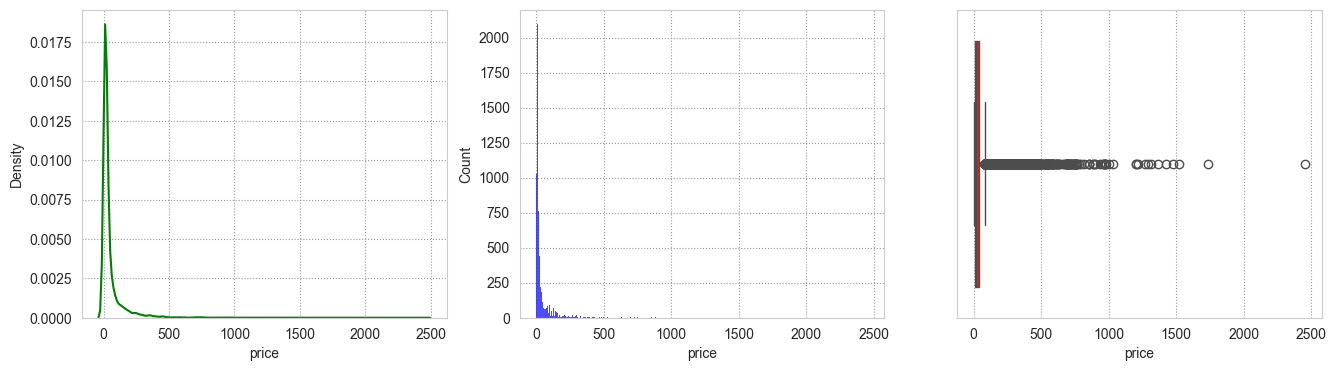

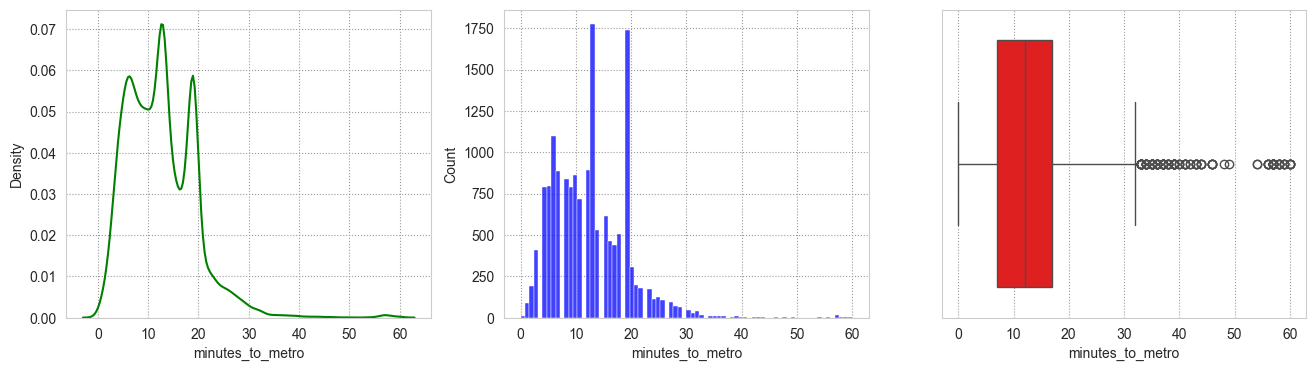

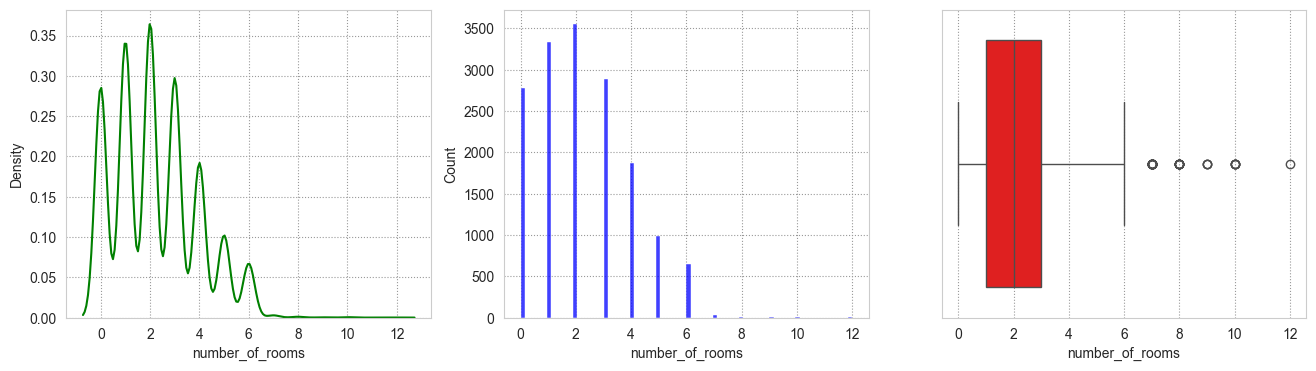

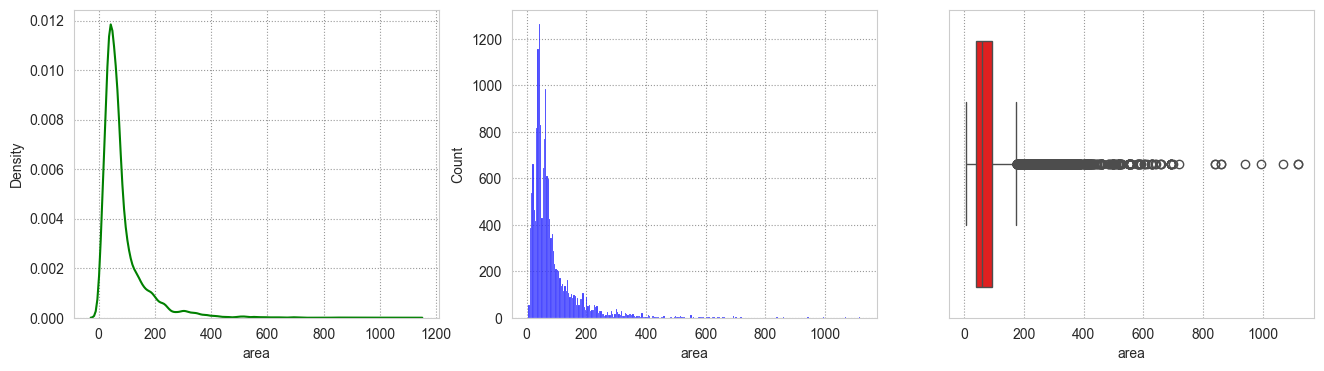

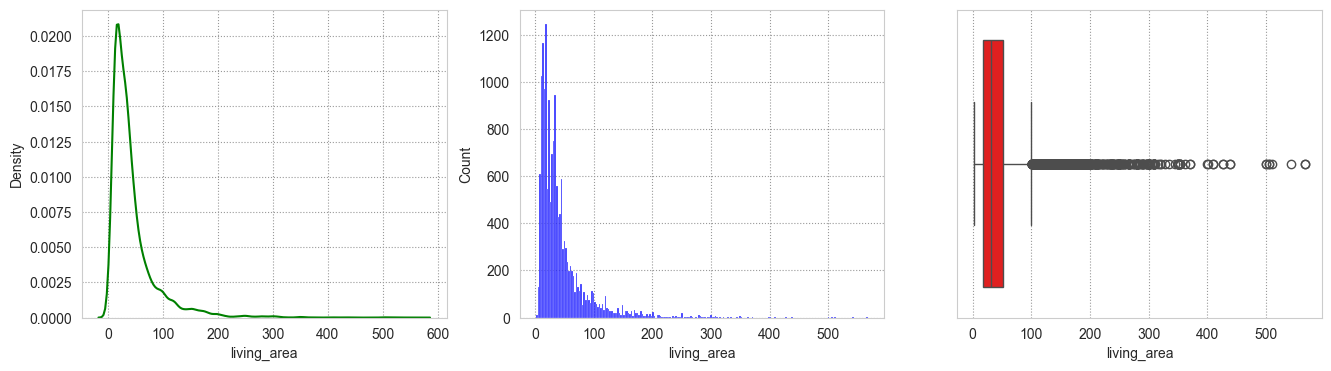

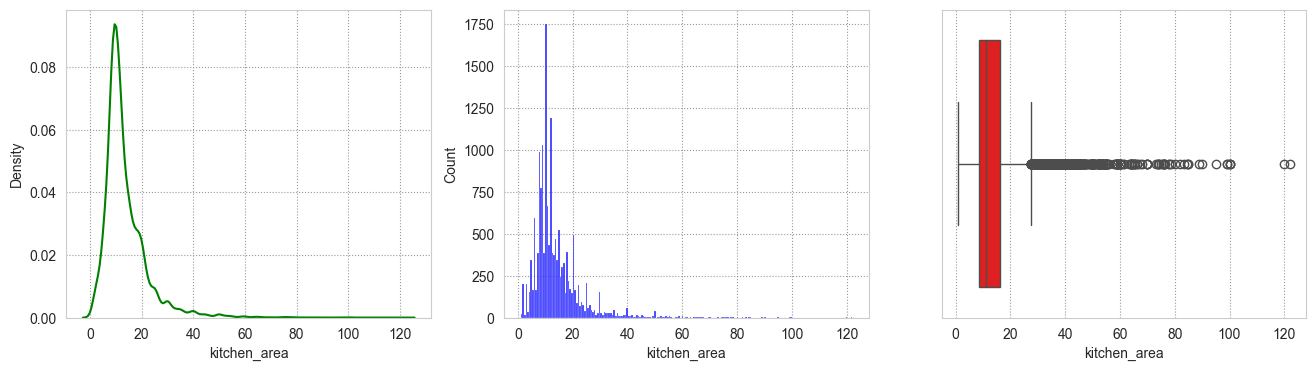

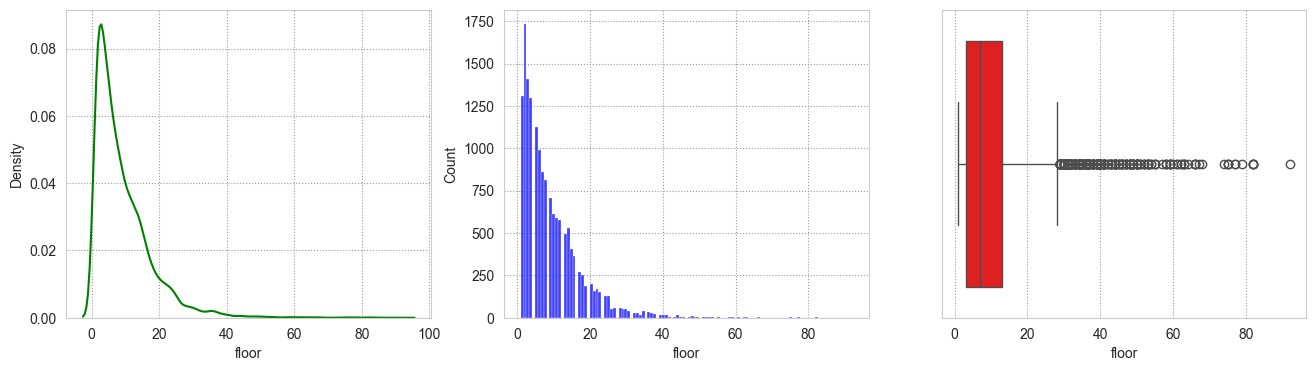

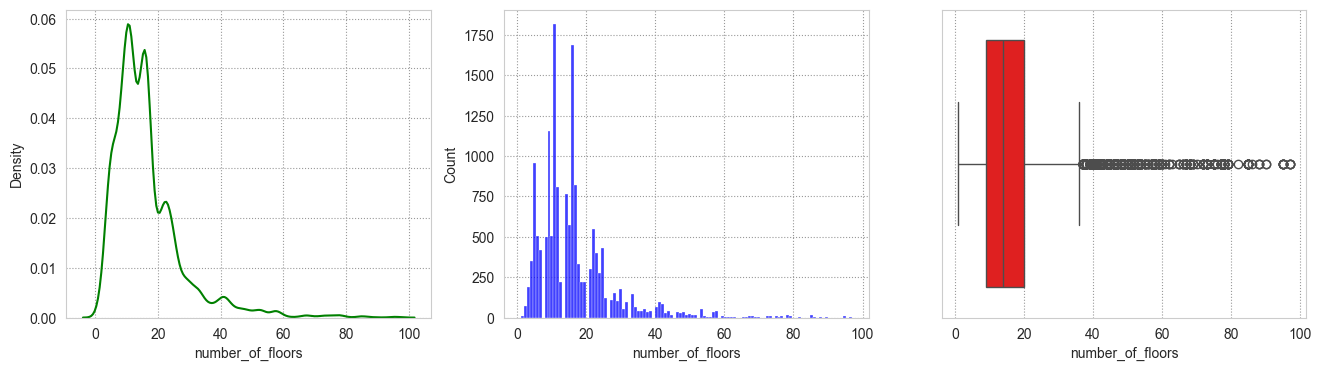

In [8]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.draw_kde_hist_boxplot(df)

Выводы:

1. price - большое количество однократных выбросов свыше значения 100 млн рублей, о виде распределения сказать что-то трудно.

2. minutes_to_metro - распределение имеет небольшое количество выбросов при значениях свыше 28 минут, но в целом наблюдается близкое к нормальному распределение (медиана и среднее совпадают).

3. number_of_rooms - редко встречаются квартиры свыше 6 комнат, в целом распределение близкое к нормальному (медиана и среднее совпадают).

4. area, living_area, kitchen_area - очень схожие между собой данные, что говорит об их избыточности. В целом наблюдается большое количество выбросов аналогичных, как на графике сценой. Возможно стоит перейти к исследованию признака "цены за квадратный метр".

5. floor - этажность выше 30 редкая, большая часть предложений это квартиры на низких этажах до 10.

6. number_of_floors - этажность выше 30 редкая, распределение построек по этажности носит близкий к нормальному характер.

In [9]:
# Разбиваем датасет на два
Q1 = df['price'].quantile(.25)
Q3 = df['price'].quantile(.75)
IQR = Q3 - Q1
mask = df['price'] < Q3 + 1.5*IQR

df_lowcost = df[mask]
Saver().save_csv(df_lowcost, 'df_lowcost', False)

df_elite = df[~mask]
Saver().save_csv(df_elite, 'df_elite', False)

print(f'цена разделяющая элитную и обычную недвижимости: {Q3 + 1.5*IQR}')

Файл успешно сохранён: ./dataset/df_lowcost.csv
Файл успешно сохранён: ./dataset/df_elite.csv
цена разделяющая элитную и обычную недвижимости: 84.7


## Анализ обычной недвижимости
Подробный анализ данных обычной недвижимости находится здесь:
[lowcost.ipynb](./lowcost.ipynb).

## Анализ элитной недвижимости
Подробный анализ данных элитной недвижимости можно найти в этом файле:
[elite.ipynb](./elite.ipynb).


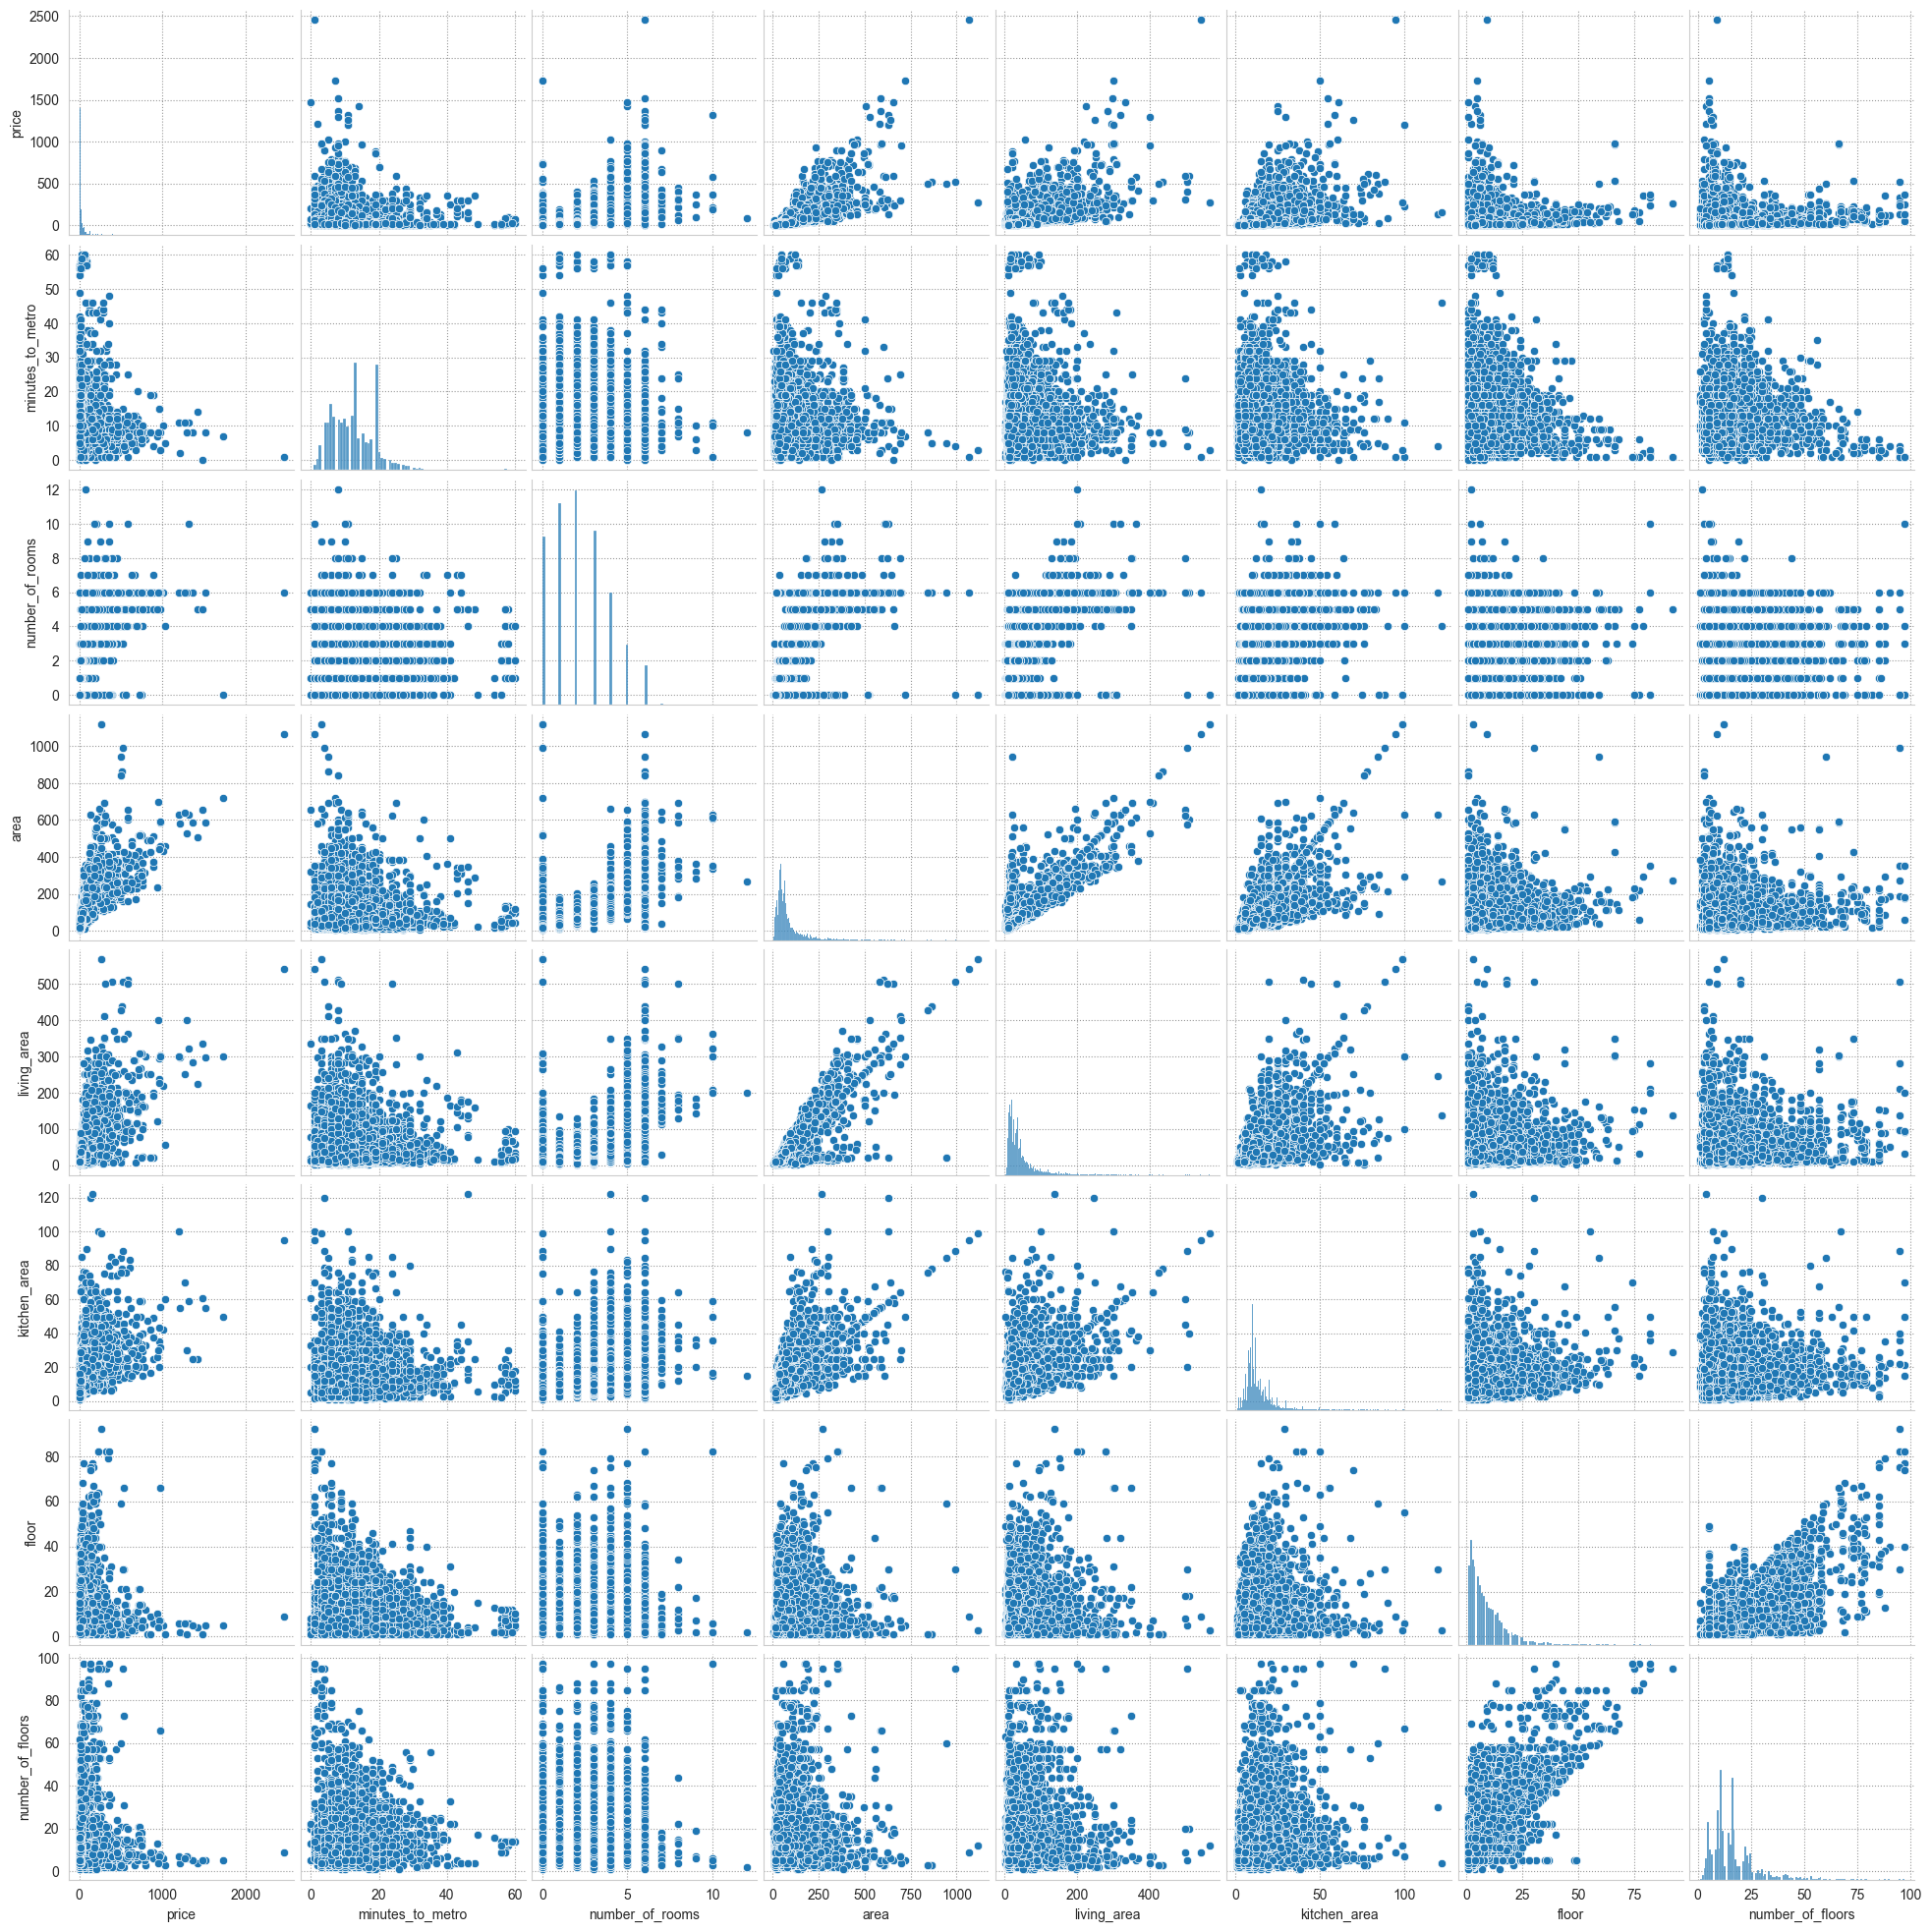

In [10]:
# Исследуем графически зависимость признаков на целевую переменную для обычной недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

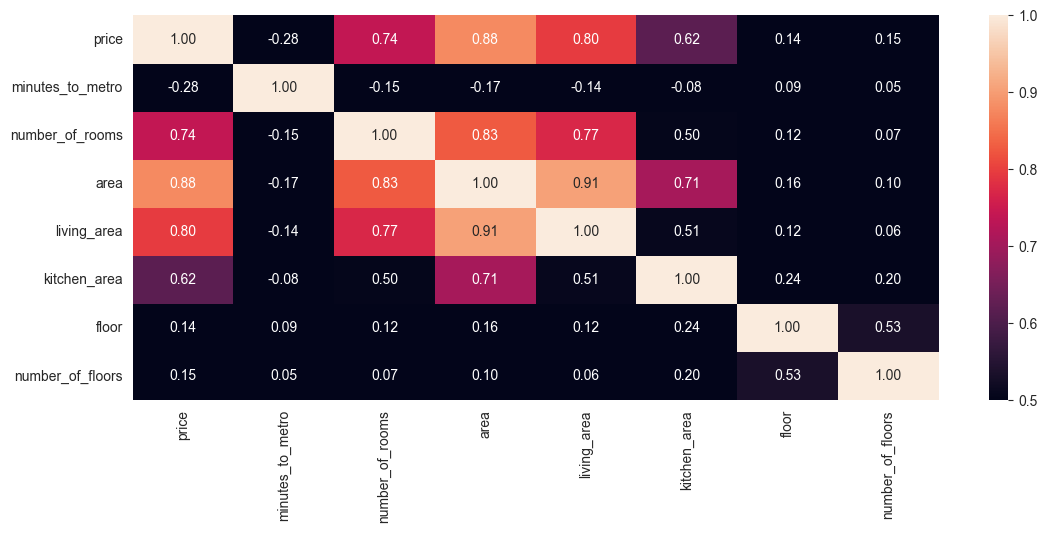

In [11]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.show()

In [12]:
# Проверим допущение о мультиколлинеарности
numeric_col = df.drop(columns='price').describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.611041
number_of_rooms,4.917673
area,16.678503
living_area,11.109298
kitchen_area,7.187860
floor,3.787128
number_of_floors,4.807750


In [13]:
# Проверим допущение о мультиколлинеарности ещё раз
numeric_col = df.drop(columns=['price', 'living_area', 'kitchen_area', 'number_of_rooms']).describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.230535
area,1.766682
floor,3.773531
number_of_floors,4.518966


Вывод: для обычной недвижимости четыре признака оказались менее 5, то есть с этими признаками можно работать

In [14]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

,apartment_type,metro_station,renovation
count,16113,16113,16113
unique,2,542,4
top,Secondary,Депо,Cosmetic
freq,12500,1646,6462


Выводы:
1. у нас всего 2 типа аппартаментов в датасете
2. у нас всего 4 вида ремонта в датасете
3. станций метро в москве слишком много (вся россия работает на благоустройство москвы)

In [15]:
StatCriteria().mannwhitneyu(df, 'apartment_type', 'price')

Mann-Whitney U test
U_statistic = 35653929.500
Распределения двух выборок не равны (p-value = 0.000).


(np.float64(35653929.5), np.float64(0.0))

In [16]:
StatCriteria().kruskal(df, 'metro_station', 'price')

kruskal
statistic = 10685.468
Медианы всех групп не равны (p-value = 0.000).


(np.float64(10685.46823896811), np.float64(0.0))

In [17]:
StatCriteria().kruskal(df, 'renovation', 'price')

kruskal
statistic = 5657.524
Медианы всех групп не равны (p-value = 0.000).


(np.float64(5657.52416188657), np.float64(0.0))

Вывод: на стоимость lowcost недвижимости влияют все категориальные переменные такие как:
1. apartment_type,
2. metro_station,
3. renovation

поэтому их все придётся учитывать при проведении регрессии.

In [18]:
df['apartment_type'] = Encoder().bolean_one_column_encoder(df['apartment_type'], 'Secondary')
df['metro_station'] = Encoder().leaveOneOutEncoder(df['metro_station'], df['price'])
df['renovation'] = Encoder().labelEncoder(df['renovation'])

In [19]:
# проверяем датасет
df.head(5)

,price,apartment_type,metro_station,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,23.00000,1,10.848125,13,4,95.699997,69.0,12.000000,12,12,0
1,8.46336,0,9.410156,19,1,44.080002,24.4,10.300000,9,11,0
2,11.29621,0,9.408434,19,2,62.410000,33.7,11.800000,12,11,0
3,110.00000,1,193.923921,46,4,212.699997,83.1,16.299999,4,4,1
4,72.25000,1,114.515857,59,4,100.000000,66.0,14.000000,12,14,3


In [20]:
# подготавливаем данные
exclude_features = ['price', 'apartment_type', 'living_area', 'kitchen_area', 'number_of_rooms']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().prepare_data(df, exclude_features, target)

# проводим нормализацию (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log_norm(X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = Normalizer().min_max_scaling(X_train, X_test, y_train, y_test)

In [21]:
# Применяем готовую линейную регрессию из библиотеки statsmodels

# Добавим константу как требование OLS
X_train_plus_const = sm.add_constant(X_train, prepend=False)
X_test_plus_const = sm.add_constant(X_test, prepend=False)

# Обучаем модель на обучающей выборке
model = OLS(y_train, X_train_plus_const).fit()

# Прогнозируем на тестовой выборке
y_pred = model.predict(X_test_plus_const)

residuals = y_test.flatten() - y_pred
print(model.summary())

MetricCalculator.show_metrics(y_test.flatten(), y_pred)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 2.458e+04
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:06:57   Log-Likelihood:                 21299.
No. Observations:               12084   AIC:                        -4.258e+04
Df Residuals:                   12077   BIC:                        -4.253e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3005      0.003    119.467      0.0

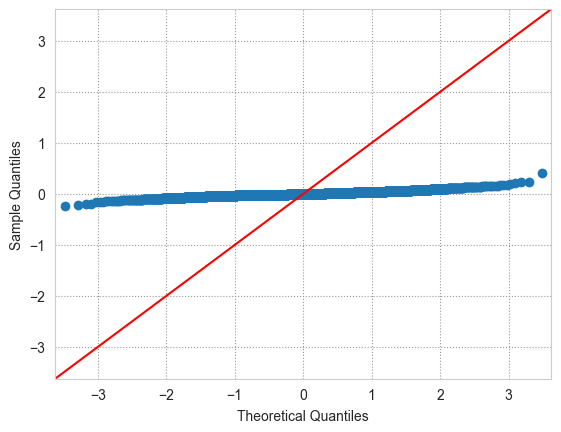

In [22]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

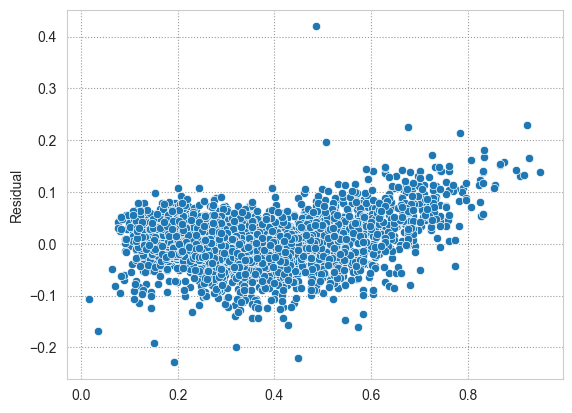

In [23]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.flatten(), y = residuals)
plt.ylabel("Residual")
plt.show()

In [24]:
# Применяем Lasso регрессию
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

# Прогнозируем на тестовой выборке
y_pred = lasso.predict(X_test)

residuals = y_test.flatten() - y_pred

print("Коэффициенты Lasso-регрессии:", lasso.coef_)

MetricCalculator.show_metrics(y_test, y_pred)

Коэффициенты Lasso-регрессии: [ 0.26077121 -0.          0.22262326  0.          0.          0.0086347 ]
MAE: 0.062256989281591985
RMSE: 0.08354941075821988


Вывод: признаки minutes_to_metro, floor, number_of_floors не сильно влияют на таргет

In [25]:
# подготавливаем данные
exclude_features = ['price', 'living_area', 'kitchen_area', 'number_of_rooms', 'minutes_to_metro', 'floor', 'number_of_floors']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().prepare_data(df, exclude_features, target)

# проводим нормализацию (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log_norm(X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = Normalizer().min_max_scaling(X_train, X_test, y_train, y_test)

In [26]:
# Применяем готовую линейную регрессию из библиотеки statsmodels

# Добавим константу как требование OLS
X_train_plus_const = sm.add_constant(X_train, prepend=False)
X_test_plus_const = sm.add_constant(X_test, prepend=False)

# Обучаем модель на обучающей выборке
model = OLS(y_train, X_train_plus_const).fit()

# Прогнозируем на тестовой выборке
y_pred = model.predict(X_test_plus_const)

residuals = y_test.flatten() - y_pred
print(model.summary())

MetricCalculator.show_metrics(y_test.flatten(), y_pred)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 3.991e+04
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:06:57   Log-Likelihood:                 21743.
No. Observations:               12084   AIC:                        -4.348e+04
Df Residuals:                   12079   BIC:                        -4.344e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0365      0.001     32.665      0.0

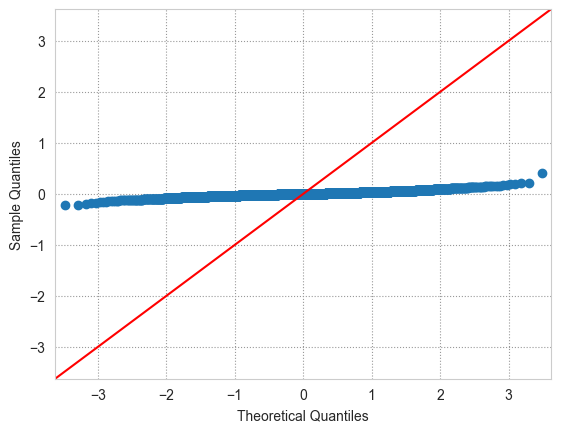

In [27]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

In [28]:
# Применяем Ridge регрессию
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, y_train)

# Прогнозируем на тестовой выборке
y_pred = ridge.predict(X_test)

residuals = y_test.flatten() - y_pred

print("Коэффициенты Ridge-регрессии:", ridge.coef_)

MetricCalculator.show_metrics(y_test.flatten(), y_pred)

Коэффициенты Ridge-регрессии: [0.03652991 0.27080935 0.68314139 0.00534782]
MAE: 0.029481263159879263
RMSE: 0.04144846866551866


In [29]:
# Подготавливаем данные
exclude_features = ['price', 'living_area', 'kitchen_area', 'number_of_rooms', 'minutes_to_metro', 'floor', 'number_of_floors']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().prepare_data(df, exclude_features, target)

# Нормализуем данные (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log_norm(X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = Normalizer().min_max_scaling(X_train, X_test, y_train, y_test)

# Трансформируем Х в полиномиальные признаки
poly_features2 = PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_features2.fit_transform(X_train)
X_test = poly_features2.transform(X_test)

In [30]:
# Применяем готовую линейную регрессию из библиотеки statsmodels

# Добавим константу как требование OLS
X_train_plus_const = sm.add_constant(X_train, prepend=False)
X_test_plus_const = sm.add_constant(X_test, prepend=False)

# Обучаем модель на обучающей выборке
model = OLS(y_train, X_train_plus_const).fit()

# Прогнозируем на тестовой выборке
y_pred = model.predict(X_test_plus_const)

residuals = y_test.flatten() - y_pred
print(model.summary())

MetricCalculator.show_metrics(y_test.flatten(), y_pred)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.489e+04
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:06:57   Log-Likelihood:                 22837.
No. Observations:               12084   AIC:                        -4.565e+04
Df Residuals:                   12070   BIC:                        -4.554e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -9.329e+10   7.32e+10     -1.275      0.2

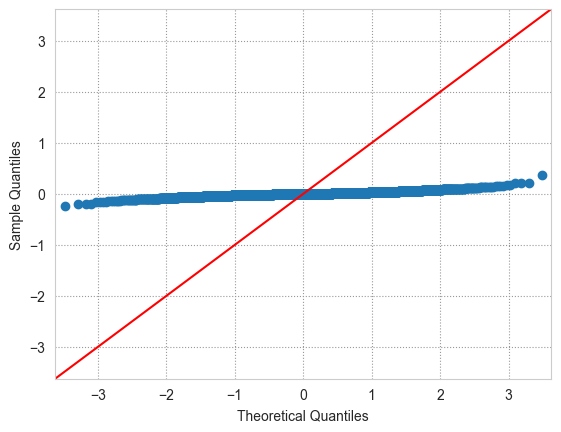

In [31]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

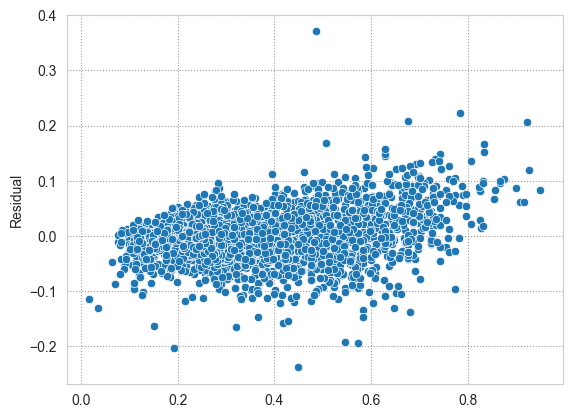

In [32]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.flatten(), y = residuals)
plt.ylabel("Residual")
plt.show()